In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('..')

In [2]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

import utils.nn as tu
import utils.vis as vis
import utils.mp as mp

from tqdm.auto import trange

T.__version__

'1.3.1'

torch.Size([16, 3, 28, 28])

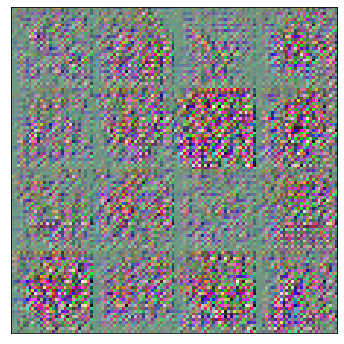

In [3]:
class MsgEncoder(nn.Module):
    def __init__(self, msg_size, img_channels):
        super().__init__()

        self.net = nn.Sequential(
            tu.reshape(-1, msg_size, 1, 1),
            tu.deconv_block(msg_size, 128 , ks=5, s=2, p=1),
            nn.Dropout(0.2),
            tu.deconv_block(128, 64, ks=5, s=1, p=2),
            nn.Dropout(0.5),
            tu.deconv_block(64, 32, ks=5, s=1, p=2),
            tu.deconv_block(32, 16, ks=5, s=2, p=1),
            nn.Dropout(0.3),
            tu.deconv_block(16, 8, ks=5, s=1, p=2),
            tu.deconv_block(8, 8, ks=5, s=1, p=2),
            nn.Dropout(0.01),
            tu.deconv_block(8, 4, ks=5, s=2, p=2),
            tu.deconv_block(4, img_channels, ks=4, s=2, p=0, a=nn.Sigmoid()),
        )

    def forward(self, z):
        return self.net(z)
    

msg_size = 15
bs = 16

encoder = MsgEncoder(msg_size, img_channels=3)
msg = T.randn(bs, msg_size)
img = encoder(msg)

img.imshow((6, 6))
img.shape

In [4]:
class MsgDecoder(nn.Module):
    def __init__(self, in_channels, msg_size):
        super().__init__()
        
        self.conv = tu.conv_to_flat(
            [in_channels, 128, 128, 64, 32],
            2,
            ks=3,
            s=2,
        )

        self.dense = nn.Sequential(
            nn.LeakyReLU(0.5),
            nn.Linear(2, 128),
            nn.LeakyReLU(0.5),
            nn.Linear(128, msg_size),
        )
        self.net = nn.Sequential(
            self.conv,
            self.dense,
        )
        
    def decode(self, x):
        return self.conv(x)
        
    def forward(self, x):
        return self.net(x)
    
bs = 16
in_channels = 3
msg_size = 32

decoder = MsgDecoder(in_channels, msg_size)
img = T.rand(bs, in_channels, 32, 32)
msg = decoder(img)
msg.shape

torch.Size([16, 32])

In [5]:
class ReverseAE(tu.Module):
    def __init__(self, msg_size, img_channels):
        super().__init__()
        self.msg_size = msg_size
        self.encoder = MsgEncoder(msg_size, img_channels)
        self.decoder = MsgDecoder(img_channels, msg_size)

        # This is done so that te decoder parameters are initialized
        imgs = self.encoder(self.sample(bs=1))
        self.decoder(imgs)

    def get_data_gen(self, bs):
        while True:
            X = self.sample(bs)
            yield X, X

    def sample(self, bs):
        return T.rand(bs, self.msg_size).to(self.device)
    
    def forward(self, bs):
        msg = self.sample(bs)
        img = self.encoder(msg)
        return img

    def configure_optim(self, lr, noise_size):
        self.noise_size = noise_size
        self.optim = T.optim.Adam(self.parameters(), lr)

    def optim_forward(self, X):
        def apply_noise(t):
            noise = T.randn(t.shape) / self.noise_size
            noise = noise.to(self.device)
            return t * noise

        bs = X.size(0)
        msg = self.sample(bs)
        img = self.encoder(msg)
        img = apply_noise(img)
        pred_msg = self.decoder(img)

        return pred_msg

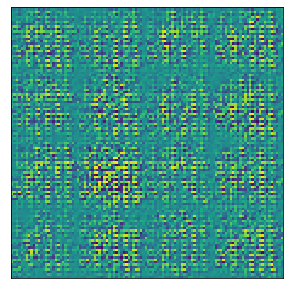

In [6]:
bs = 16
msg_size = 32

model = ReverseAE(msg_size, img_channels=1)
model = model.to('cuda')

for _ in range(5):
    model.configure_optim(lr=0.001, noise_size=0.5)
    X = model.sample(bs=128)
    loss, info = model.optim_step([X, X])

model(16).imshow(5)

In [7]:
import torchvision
from torchvision import transforms

In [39]:
def get_mnist_iterator(bs):
    dataset = torchvision.datasets.MNIST(
        root='./data',
        train=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1307,), (0.3081,))
        ]),
        download=True
    )
    dl = T.utils.data.DataLoader(
        dataset=dataset,
        batch_size=bs,
        # shuffle=True
    )
    it = iter(dl)

    while True:
        try:
            yield it.next()
        except StopIteration:
            it = iter(dl)

X, y = next(get_mnist_iterator(2048))
X.shape

torch.Size([2048, 1, 28, 28])

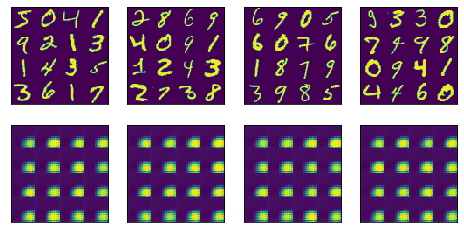

In [40]:
%matplotlib inline

imgs = X[:64].to('cuda')
labels = y[:64]

msg = model.decoder(imgs)
pred_img = model.encoder(msg)

T.cat([
    imgs.reshape(1, 4, 4, 4, 1, 28, 28),
    pred_img.reshape(1, 4, 4, 4, 1, 28, 28),
]).imshow([8, 4])

In [41]:
msg_size = 32
model = ReverseAE(msg_size, img_channels=1)
model = model.to('cuda')

<IPython.core.display.Javascript object>


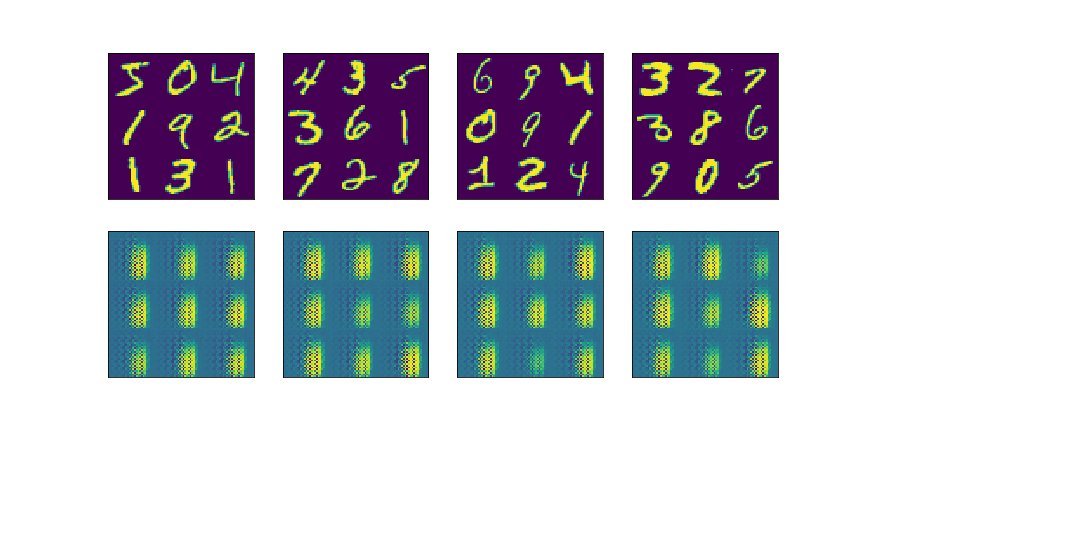

<IPython.core.display.Javascript object>


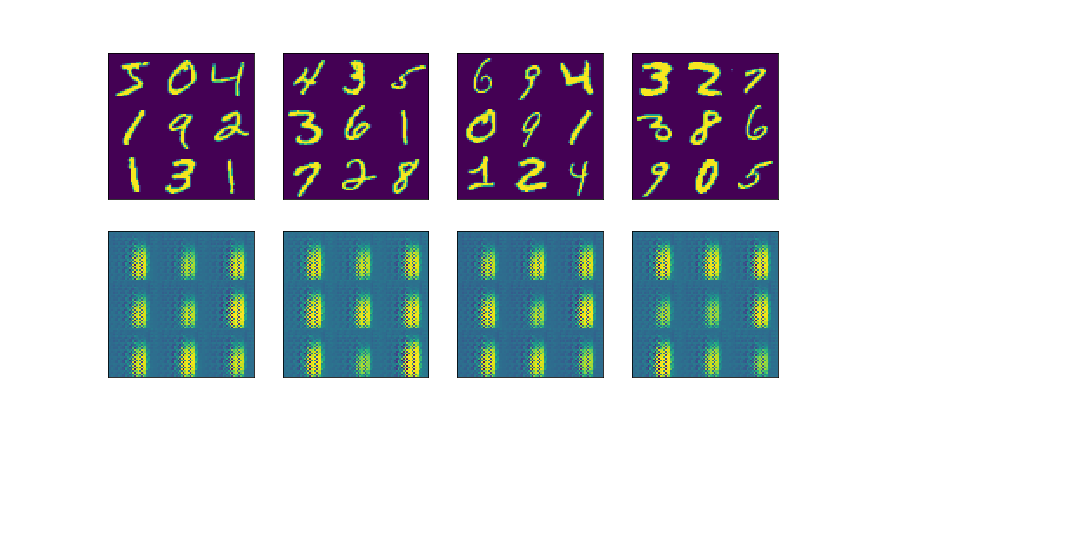

<IPython.core.display.Javascript object>


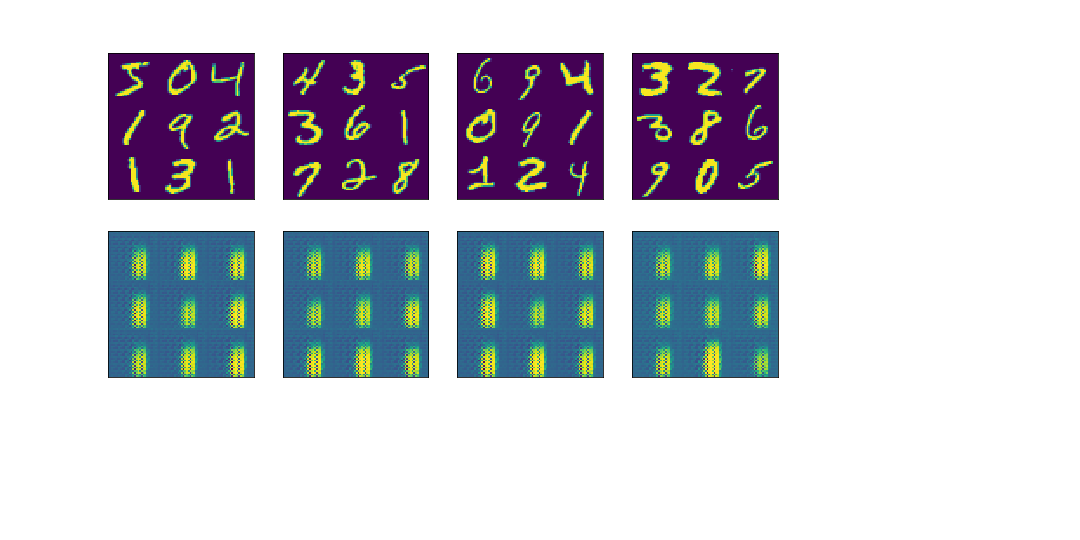

<IPython.core.display.Javascript object>


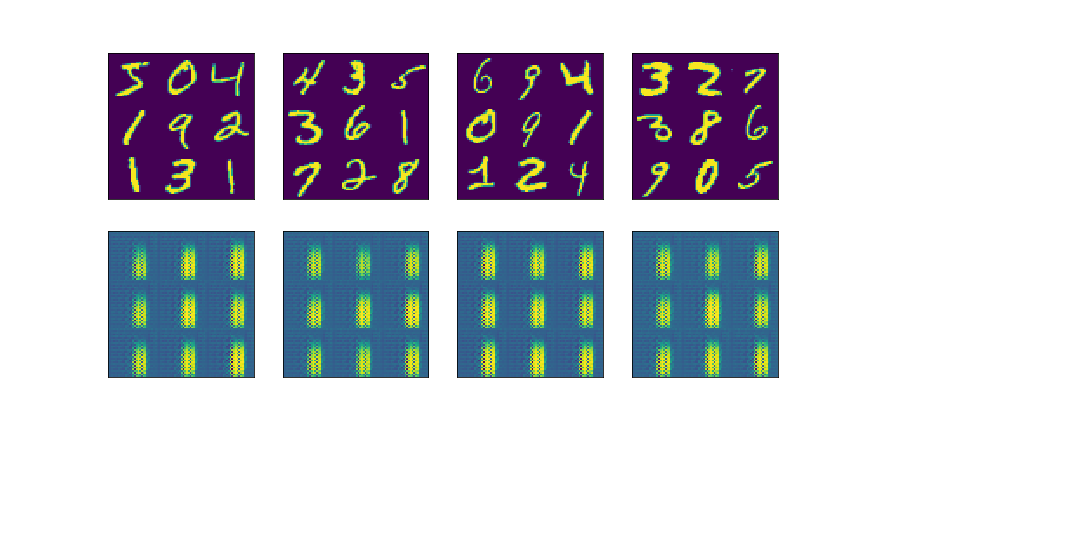

<IPython.core.display.Javascript object>


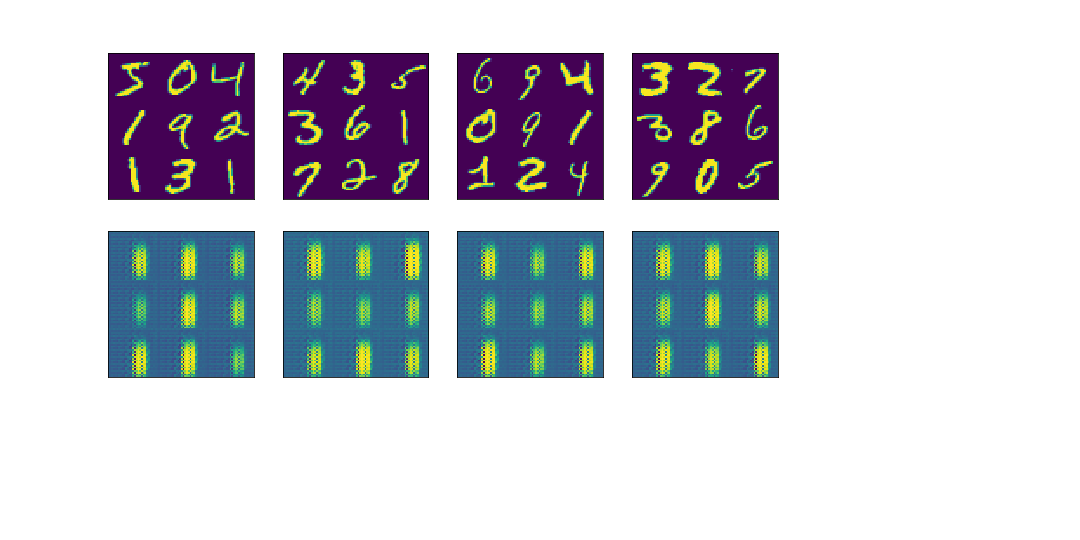

In [43]:
%matplotlib notebook

epochs = 5
for e in range(epochs):
    model.configure_optim(lr=0.001, noise_size=0.5)

    with vis.fig(figsize=[12, 6]) as ctx, mp.fit(
        model=model,
        its=512,
        data_gen=model.get_data_gen(bs=128),
    ) as fit:
        for i in fit.wait:
            if i % 5 == 0:
                imgs = X[:36].to('cuda')

                msg = model.decoder(imgs)
                pred_img = model.encoder(msg)

#                 ctx.clear()
                T.cat([
                    imgs.reshape    (1, 4, 3, 3, 1, 28, 28),
                    pred_img.reshape(1, 4, 3, 3, 1, 28, 28),
                ]).imshow()


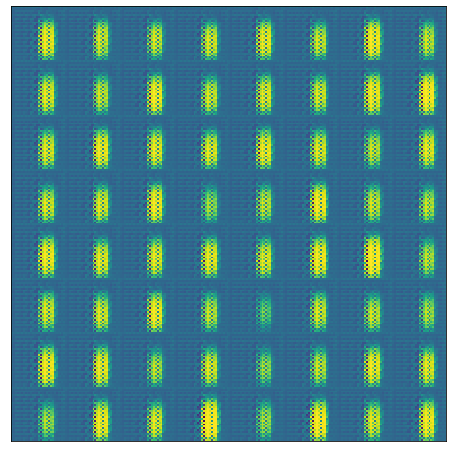

In [45]:
%matplotlib inline
model(64).imshow()

In [46]:
def plot_emb_2d(label, pos):
    colors = [
        '#1f77b4', '#ff7f0e', '#2ca02c',
        '#d62728', '#9467bd', '#8c564b',
        '#e377c2', '#7f7f7f', '#bcbd22',
        '#17becf'
    ]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)

    pad = 0.01
    s = 0.05
    ax.set_xlim(pos[:,1].min() - pad, pos[:,1].max() + s + pad)
    ax.set_ylim(pos[:,0].min() - pad, pos[:,0].max() + s + pad)

    for idx in range(len(img)):
        y, x = pos[idx][0], pos[idx][1]
        c = colors[label[idx]]
        ax.scatter(x, y, c=c)
    plt.show()

In [47]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, svd_solver='full')
pca.fit(X.reshape(-1, 28 * 28))

print(pca.explained_variance_ratio_)
print(pca.singular_values_)

pos = pca.transform(X.reshape(-1, 28 * 28))

[0.100068   0.07503897]
[335.49844193 290.52689435]


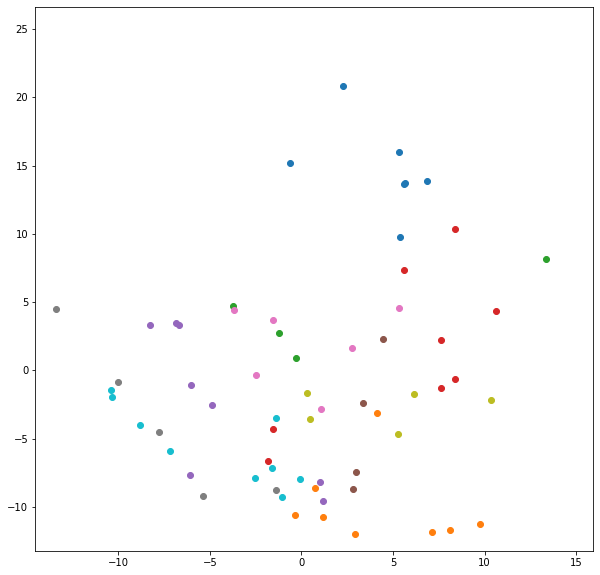

In [48]:
plot_emb_2d(y.detach().cpu().numpy(), pos)

<IPython.core.display.Javascript object>


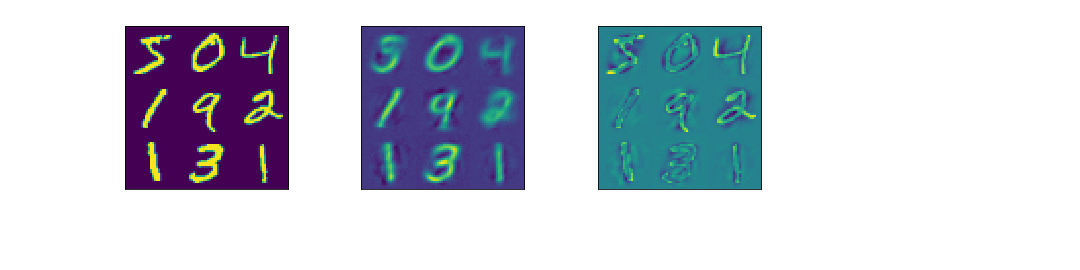

In [88]:
from IPython.display import clear_output
%matplotlib notebook

with vis.fig(figsize=[12, 3]) as ctx, mp.fit(
    model=tu.DenseAE(hid_size=32),
    its=1024,
    data_gen=([x, x] for x, y in get_mnist_iterator(bs=128)),
    optim_kw={'lr': 0.001}
) as fit:
    while not fit.done:
        imgs = X[:9]
        pred_imgs = fit.model(imgs)

#         clear_output(wait=True)
#         ctx.clear()
        T.cat([
            imgs.reshape              (1, 1, 3, 3, 1, 28, 28),
            pred_imgs.reshape         (1, 1, 3, 3, 1, 28, 28),
            (imgs - pred_imgs).reshape(1, 1, 3, 3, 1, 28, 28),
        ], dim=1).imshow()

#         plt.show()